## Import Libraries

In [274]:

import os
import pandas as pd

from functools import reduce

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, KFold

import nltk
import seaborn as sns
import matplotlib.pyplot as plt

import numpy as np  
import re  
import nltk 

import time

import math
 
import pickle  
from nltk.corpus import stopwords

from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import BernoulliNB, ComplementNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.utils.extmath import density
from sklearn import metrics

from keras.utils import to_categorical

from keras.models import Sequential
from keras.layers import Dense, Dropout

## Create Train and Test DF

In [196]:

ROOT_DIR = r'/Users/shabhushan/Desktop/python/python-code/dataset/notracking/participants'
#ROOT_DIR = r'/home/shashi/Desktop/projects/python-code/dataset/notracking/participants'
TRAIN_LABELS = os.path.join(ROOT_DIR, r'train', r'labels', r'labels.csv')
TRAIN_TEXT = os.path.join(ROOT_DIR, r'train', r'extracted_data', r'extract_combined.csv')
TEST_TEXT = os.path.join(ROOT_DIR, r'test', r'extracted_data', r'extract_combined.csv')


In [197]:

# read in training and testing data
# one dataframe for labels another for text features
train_labels_df = pd.read_csv(TRAIN_LABELS, usecols=['document_name','is_fitara'])
train_text_df = pd.read_csv(TRAIN_TEXT)
test_df = pd.read_csv(TEST_TEXT)

# combine labels with text features
train_df = pd.merge(
    train_labels_df, 
    train_text_df, 
    on='document_name', 
    how='inner'
)

# remove dataframes that are no longer needed from memory 
del train_labels_df
del train_text_df


In [198]:
train_df['is_fitara'] = train_df['is_fitara'].map({'No': 0, 'Yes': 1})

## EDA

Since Positive and Negative classes are size 71% and 29% respectively. Hence, no severe class imbalance.

In [199]:

# confirm class distribution
# is_fitara - yes: ~29%; no: ~71%
train_df['is_fitara'].value_counts(normalize=True)


0    0.713089
1    0.286911
Name: is_fitara, dtype: float64

In [8]:
pd.read_csv(TRAIN_LABELS).isnull().sum()

solicitation_id                77
contract_award_number         824
document_name                   0
is_fitara                       0
contains_statement_of_work      0
dtype: int64

In [9]:
def get_set_from_word_list(lst):
    temp_set_list = [set(nltk.word_tokenize(words)) for words in lst]

    return reduce(lambda x, y: {*x, *y}, temp_set_list)

In [10]:
#set_no = get_set_from_word_list(train_df_temp)
def get_word_frequency(df):
    tokenized_words = [nltk.word_tokenize(words) for words in df]
    words_list = reduce(lambda x, y: [*x, *y], tokenized_words)

    vectorizer = CountVectorizer(stop_words='english')
    vectorizer.fit_transform(words_list)

    return pd.DataFrame(vectorizer.vocabulary_.items(), columns=['Text', 'Frequency']).sort_values(by='Frequency', ascending=False)

In [200]:
def get_tf_idf(train_df, test_df):
    vectorizer = TfidfVectorizer(stop_words='english', use_idf=True)
    X_train = vectorizer.fit_transform(train_df)
    
    X_test = vectorizer.transform(test_df)

    return X_train, X_test, vectorizer.get_feature_names() #pd.DataFrame(X.toarray(), columns = vectorizer.get_feature_names()), X

In [12]:
#tokenized_words = [nltk.word_tokenize(words) for words in train_df_temp]
#words_list = reduce(lambda x, y: [*x, *y], tokenized_words)

#vectorizer = CountVectorizer(stop_words='english')
#vectorizer.fit_transform(words_list)

#pd.DataFrame(vectorizer.vocabulary_.items(), columns=['Text', 'Frequency']).sort_values(by='Frequency', ascending=False)

## Ablation Experiment

In [201]:
train_df_no = train_df[train_df.is_fitara == 0]
train_df_yes = train_df[train_df.is_fitara == 1]

In [202]:
# Get 15% of total Records for Ablation
ablation = 0.15
train_df_no_ablation = train_df_no.loc[0:int(len(train_df_no) * ablation)]
train_df_yes_ablation = train_df_yes.loc[0:int(len(train_df_yes) * ablation)]

In [203]:
train_df_ablation = pd.concat([train_df_yes_ablation, train_df_no_ablation]).sample(frac=1).reset_index(drop=True)

X = train_df_ablation.drop(['is_fitara'], axis=1)
y = train_df_ablation['is_fitara']

X_train_split, X_test_split, y_train, y_test = train_test_split(X, y, test_size=0.25)
#get_tf_idf(train_df_ablation['text'])
#train_df_ablation


In [204]:
X_train, X_test, feature_names = get_tf_idf(X_train_split['text'], X_test_split['text'])

In [90]:
%%time

model = SVC(kernel='linear', C=100, probability=True, random_state=0)

model.fit(X_train, y_train)

pred = model.predict(X_test)
pred_proba = model.predict_proba(X_test)



CPU times: user 94.2 ms, sys: 5.58 ms, total: 99.8 ms
Wall time: 99.2 ms


In [322]:
# create model
model = Sequential()
model.add(Dense(35, input_dim=X_train.toarray().shape[1], activation='sigmoid'))
model.add(Dropout(0.25))
model.add(Dense(10, activation='sigmoid'))
model.add(Dense(2, activation='softmax'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

# train model
history = model.fit(X_train.toarray(), to_categorical(y_train, 2), epochs=400, batch_size=10, verbose=2)#, class_weight={1:0.96, 0:0.04})

Epoch 1/400
 - 1s - loss: 1.1362 - acc: 0.1667
Epoch 2/400
 - 0s - loss: 0.9925 - acc: 0.1667
Epoch 3/400
 - 0s - loss: 0.8584 - acc: 0.1667
Epoch 4/400
 - 0s - loss: 0.7600 - acc: 0.2361
Epoch 5/400
 - 0s - loss: 0.6858 - acc: 0.5972
Epoch 6/400
 - 0s - loss: 0.6113 - acc: 0.8611
Epoch 7/400
 - 0s - loss: 0.5652 - acc: 0.8333
Epoch 8/400
 - 0s - loss: 0.5257 - acc: 0.8333
Epoch 9/400
 - 0s - loss: 0.4853 - acc: 0.8333
Epoch 10/400
 - 0s - loss: 0.4822 - acc: 0.8333
Epoch 11/400
 - 0s - loss: 0.4597 - acc: 0.8333
Epoch 12/400
 - 0s - loss: 0.4527 - acc: 0.8333
Epoch 13/400
 - 0s - loss: 0.4462 - acc: 0.8333
Epoch 14/400
 - 0s - loss: 0.4427 - acc: 0.8333
Epoch 15/400
 - 0s - loss: 0.4436 - acc: 0.8333
Epoch 16/400
 - 0s - loss: 0.4182 - acc: 0.8333
Epoch 17/400
 - 0s - loss: 0.4382 - acc: 0.8333
Epoch 18/400
 - 0s - loss: 0.4208 - acc: 0.8333
Epoch 19/400
 - 0s - loss: 0.4198 - acc: 0.8333
Epoch 20/400
 - 0s - loss: 0.4067 - acc: 0.8333
Epoch 21/400
 - 0s - loss: 0.4070 - acc: 0.8333
E

Epoch 171/400
 - 0s - loss: 0.0177 - acc: 1.0000
Epoch 172/400
 - 0s - loss: 0.0173 - acc: 1.0000
Epoch 173/400
 - 0s - loss: 0.0169 - acc: 1.0000
Epoch 174/400
 - 0s - loss: 0.0186 - acc: 1.0000
Epoch 175/400
 - 0s - loss: 0.0147 - acc: 1.0000
Epoch 176/400
 - 0s - loss: 0.0168 - acc: 1.0000
Epoch 177/400
 - 0s - loss: 0.0162 - acc: 1.0000
Epoch 178/400
 - 0s - loss: 0.0181 - acc: 1.0000
Epoch 179/400
 - 0s - loss: 0.0156 - acc: 1.0000
Epoch 180/400
 - 0s - loss: 0.0147 - acc: 1.0000
Epoch 181/400
 - 0s - loss: 0.0252 - acc: 1.0000
Epoch 182/400
 - 0s - loss: 0.0184 - acc: 1.0000
Epoch 183/400
 - 0s - loss: 0.0165 - acc: 1.0000
Epoch 184/400
 - 0s - loss: 0.0152 - acc: 1.0000
Epoch 185/400
 - 0s - loss: 0.0141 - acc: 1.0000
Epoch 186/400
 - 0s - loss: 0.0151 - acc: 1.0000
Epoch 187/400
 - 0s - loss: 0.0138 - acc: 1.0000
Epoch 188/400
 - 0s - loss: 0.0133 - acc: 1.0000
Epoch 189/400
 - 0s - loss: 0.0159 - acc: 1.0000
Epoch 190/400
 - 0s - loss: 0.0159 - acc: 1.0000
Epoch 191/400
 - 0s 

 - 0s - loss: 0.0046 - acc: 1.0000
Epoch 339/400
 - 0s - loss: 0.0034 - acc: 1.0000
Epoch 340/400
 - 0s - loss: 0.0047 - acc: 1.0000
Epoch 341/400
 - 0s - loss: 0.0045 - acc: 1.0000
Epoch 342/400
 - 0s - loss: 0.0035 - acc: 1.0000
Epoch 343/400
 - 0s - loss: 0.0094 - acc: 1.0000
Epoch 344/400
 - 0s - loss: 0.0036 - acc: 1.0000
Epoch 345/400
 - 0s - loss: 0.0042 - acc: 1.0000
Epoch 346/400
 - 0s - loss: 0.0039 - acc: 1.0000
Epoch 347/400
 - 0s - loss: 0.0032 - acc: 1.0000
Epoch 348/400
 - 0s - loss: 0.0035 - acc: 1.0000
Epoch 349/400
 - 0s - loss: 0.0040 - acc: 1.0000
Epoch 350/400
 - 0s - loss: 0.0035 - acc: 1.0000
Epoch 351/400
 - 0s - loss: 0.0030 - acc: 1.0000
Epoch 352/400
 - 0s - loss: 0.0040 - acc: 1.0000
Epoch 353/400
 - 0s - loss: 0.0032 - acc: 1.0000
Epoch 354/400
 - 0s - loss: 0.0033 - acc: 1.0000
Epoch 355/400
 - 0s - loss: 0.0031 - acc: 1.0000
Epoch 356/400
 - 0s - loss: 0.0033 - acc: 1.0000
Epoch 357/400
 - 0s - loss: 0.0043 - acc: 1.0000
Epoch 358/400
 - 0s - loss: 0.0037

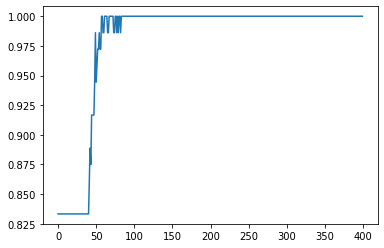

In [302]:
# plot metrics
plt.plot(history.history['acc'])
plt.show()

In [323]:
#print(y_test.values)
#print(pred)
#print(pred_proba)

num = metrics.log_loss(y_test.values, model.predict(X_test))


#math.exp(-num)
print(num)
print(math.exp(-num))
print(y_test.values)
print(np.round(model.predict(X_test)))

0.5901795320338957
0.5542277741625697
[0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
[[1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]]


## Model Running

In [23]:
def trim(s):
    """Trim string to fit on terminal (assuming 80-column display)"""
    return s if len(s) <= 80 else s[:77] + "..."

# #############################################################################
# Benchmark classifiers
def benchmark(clf):
    print('_' * 80)
    print("Training: ")
    print(clf)
    t0 = time.time()
    clf.fit(X_train, y_train)
    train_time = time.time() - t0
    print("train time: %0.3fs" % train_time)

    t0 = time.time()
    pred = clf.predict(X_test)
    test_time = time.time() - t0
    print("test time:  %0.3fs" % test_time)

    score = metrics.log_loss(y_test, pred)
    print("accuracy:   %0.3f" % score)
    """
    if hasattr(clf, 'coef_'):
        print("dimensionality: %d" % clf.coef_.shape[1])
        print("density: %f" % density(clf.coef_))

        #if opts.print_top10 and feature_names is not None:
        print("top 10 keywords per class:")
        for i, label in enumerate(target_names):
            top10 = np.argsort(clf.coef_[i])[-10:]
            print(trim("%s: %s" % (label, " ".join(feature_names[top10]))))
        print()
    """
    #if opts.print_report:
    print("classification report:")
    print(metrics.classification_report(y_test, pred))

    #if opts.print_cm:
    print("confusion matrix:")
    print(metrics.confusion_matrix(y_test, pred))

    print()
    clf_descr = str(clf).split('(')[0]
    return clf_descr, score, train_time, test_time

In [24]:
results = []
for clf, name in (
        (RidgeClassifier(tol=1e-2, solver="sag"), "Ridge Classifier"),
        (Perceptron(max_iter=50, tol=1e-3), "Perceptron"),
        (PassiveAggressiveClassifier(max_iter=50, tol=1e-3),
         "Passive-Aggressive"),
        (KNeighborsClassifier(n_neighbors=10), "kNN"),
        (RandomForestClassifier(n_estimators=100), "Random forest")):
    print('=' * 80)
    print(name)
    results.append(benchmark(clf))

Ridge Classifier
________________________________________________________________________________
Training: 
RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
                max_iter=None, normalize=False, random_state=None, solver='sag',
                tol=0.01)
train time: 0.009s
test time:  0.000s
accuracy:   4.317
classification report:
              precision    recall  f1-score   support

           0       0.88      1.00      0.93        21
           1       0.00      0.00      0.00         3

    accuracy                           0.88        24
   macro avg       0.44      0.50      0.47        24
weighted avg       0.77      0.88      0.82        24

confusion matrix:
[[21  0]
 [ 3  0]]

Perceptron
________________________________________________________________________________
Training: 
Perceptron(alpha=0.0001, class_weight=None, early_stopping=False, eta0=1.0,
           fit_intercept=True, max_iter=50, n_iter_no_change=5, n_jobs=None,
     

/home/shashi/.local/share/virtualenvs/python-code-gqSjhHCu/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/shashi/.local/share/virtualenvs/python-code-gqSjhHCu/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/shashi/.local/share/virtualenvs/python-code-gqSjhHCu/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [25]:
for penalty in ["l2", "l1"]:
    print('=' * 80)
    print("%s penalty" % penalty.upper())
    # Train Liblinear model
    results.append(benchmark(LinearSVC(penalty=penalty, dual=False,
                                       tol=1e-3)))

    # Train SGD model
    results.append(benchmark(SGDClassifier(alpha=.0001, max_iter=50,
                                           penalty=penalty)))

# Train SGD with Elastic Net penalty
print('=' * 80)
print("Elastic-Net penalty")
results.append(benchmark(SGDClassifier(alpha=.0001, max_iter=50,
                                       penalty="elasticnet")))

# Train NearestCentroid without threshold
print('=' * 80)
print("NearestCentroid (aka Rocchio classifier)")
results.append(benchmark(NearestCentroid()))

# Train sparse Naive Bayes classifiers
print('=' * 80)
print("Naive Bayes")
results.append(benchmark(MultinomialNB(alpha=.01)))
results.append(benchmark(BernoulliNB(alpha=.01)))
results.append(benchmark(ComplementNB(alpha=.1)))

print('=' * 80)
print("LinearSVC with L1-based feature selection")
# The smaller C, the stronger the regularization.
# The more regularization, the more sparsity.
results.append(benchmark(Pipeline([
  ('feature_selection', SelectFromModel(LinearSVC(penalty="l1", dual=False,
                                                  tol=1e-3))),
  ('classification', LinearSVC(penalty="l2"))])))

L2 penalty
________________________________________________________________________________
Training: 
LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.001,
          verbose=0)
train time: 0.014s
test time:  0.000s
accuracy:   5.756
classification report:
              precision    recall  f1-score   support

           0       0.87      0.95      0.91        21
           1       0.00      0.00      0.00         3

    accuracy                           0.83        24
   macro avg       0.43      0.48      0.45        24
weighted avg       0.76      0.83      0.80        24

confusion matrix:
[[20  1]
 [ 3  0]]

________________________________________________________________________________
Training: 
SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_interc

/home/shashi/.local/share/virtualenvs/python-code-gqSjhHCu/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/shashi/.local/share/virtualenvs/python-code-gqSjhHCu/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/shashi/.local/share/virtualenvs/python-code-gqSjhHCu/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


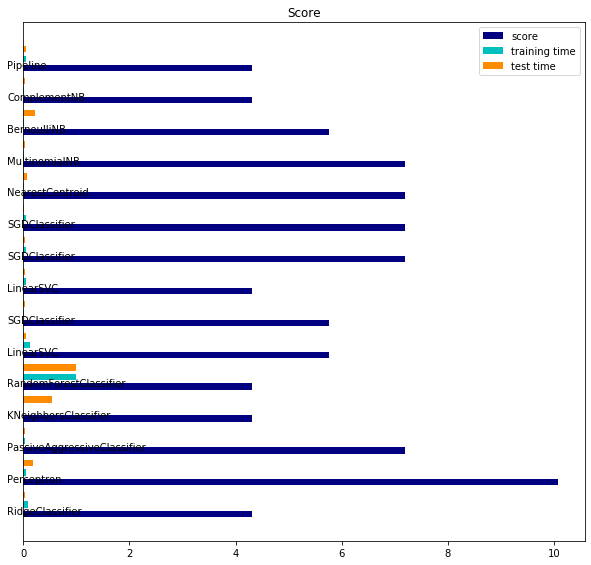

In [26]:
# make some plots

indices = np.arange(len(results))

results = [[x[i] for x in results] for i in range(4)]

clf_names, score, training_time, test_time = results
training_time = np.array(training_time) / np.max(training_time)
test_time = np.array(test_time) / np.max(test_time)

plt.figure(figsize=(12, 8))
plt.title("Score")
plt.barh(indices, score, .2, label="score", color='navy')
plt.barh(indices + .3, training_time, .2, label="training time",
         color='c')
plt.barh(indices + .6, test_time, .2, label="test time", color='darkorange')
plt.yticks(())
plt.legend(loc='best')
plt.subplots_adjust(left=.25)
plt.subplots_adjust(top=.95)
plt.subplots_adjust(bottom=.05)

for i, c in zip(indices, clf_names):
    plt.text(-.3, i, c)

plt.show()